This code predicts temperature values in unknown wells using the Gradient Boosting Regressor machine learning technique. Spatial weights to the closest wells are incorporated into the prediction. The predicted temperature gradients are cleaned of noise by fitting a regression line. The results can be visualized on a plot and are also available in the final DataFrame.

In [181]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [182]:
pip install lasio


In [183]:
#Import necessary libraries
import lasio
import pandas as pd
import os
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.spatial.distance import cdist

# 1. Upload and remove nan values from the las files

In [184]:
#Define a function to process a single .las file
def process_las_file(file_path):
    las = lasio.read(file_path)

    # Note: Ensure the column names match the ones in your LAS files
    depth = las['DEPT']
    temp = las['TEMP_GRADIENT']

    # Create a DataFrame
    df = pd.DataFrame({
        'Depth': depth,
        'Temp': temp
    })

    # Add the Well_name column (use file name or LAS metadata)
    well_name = os.path.basename(file_path).split('.')[0]  # File name without extension
    df['Well_name'] = well_name

    return df

In [185]:
#Process all .las files in a directory
def combine_las_files(directory_path):
    combined_data = []

    # Loop through all .las files in the directory
    for file_name in os.listdir(directory_path):
        if file_name.endswith('.las'):
            file_path = os.path.join(directory_path, file_name)
            df = process_las_file(file_path)
            combined_data.append(df)

    # Combine all DataFrames into one
    combined_df = pd.concat(combined_data, ignore_index=True)
    combined_df.reset_index(inplace=True)
    combined_df.rename(columns={'index': 'Index'}, inplace=True)
    return combined_df

In [186]:
directory_path = "/content/Wells"
las_df = combine_las_files(directory_path)

In [187]:
las_df
#final_df.to_csv("combined_wells.csv", index=False)

,Index,Depth,Temp,Well_name
0,0,0.0,25.000000,VIROVITICA-3ALFA
1,1,0.1,25.004900,VIROVITICA-3ALFA
2,2,0.2,25.009800,VIROVITICA-3ALFA
3,3,0.3,25.014700,VIROVITICA-3ALFA
4,4,0.4,25.019600,VIROVITICA-3ALFA
...,...,...,...,...
213131,213131,4553.6,261.787201,REZOVACCKE_KRCCEVINE-2
213132,213132,4553.7,261.792389,REZOVACCKE_KRCCEVINE-2
213133,213133,4553.8,261.797607,REZOVACCKE_KRCCEVINE-2
213134,213134,4553.9,261.802795,REZOVACCKE_KRCCEVINE-2


In [188]:
#Check for missing values
total_nan = las_df.isnull().sum().sum()
print(f"Total number of NaN values: {total_nan}")

Total number of NaN values: 0


In [189]:
# Remove rows with NaN values
las_df = las_df.dropna()

In [190]:
las_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213136 entries, 0 to 213135
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Index      213136 non-null  int64  
 1   Depth      213136 non-null  float64
 2   Temp       213136 non-null  float64
 3   Well_name  213136 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 6.5+ MB


# 2. Prepare the data frame with wells location

In [191]:
wells_location = {"Well_name":["REZOVACCKE_KRCCEVINE-1", "REZOVACCKE_KRCCEVINE-2", "SUHOPOLJE-1","VIROVITICA-1","VIROVITICA-3ALFA", "LONCCARICA-1", "Unkown-1", "Unkown-2"],
                  "X":[689340.71,688872.79,693135.92,685448.76,686218.75,680935.09,683447.00, 691636.00],
                  "Y":[5072557.33,5073318.89,5073660.97,5073267.09,5073539.22,5070578.64,5072765.00,5072723.00],
                  "TD": [3312.0,4554.0,4987.5,2956.5,4087.0,1764.0,2034.0,5435.0]
                  }

wells_location = pd.DataFrame(wells_location)

In [192]:
known_wells = wells_location[~wells_location['Well_name'].isin(['Unkown-1', 'Unkown-2'])]
unknown_wells = wells_location[wells_location['Well_name'].isin(['Unkown-1', 'Unkown-2'])]

In [193]:
# Merge logs with locations
def prepare_data(df_logs, df_locations):
    df_merged = pd.merge(df_logs, df_locations, on='Well_name', how='inner')
    df_merged = df_merged[['Well_name', 'Depth', 'X', 'Y', 'Temp']]
    return df_merged

In [194]:
df_merged = prepare_data(las_df, known_wells)

In [195]:
df_merged

,Well_name,Depth,X,Y,Temp
0,VIROVITICA-3ALFA,0.0,686218.75,5073539.22,25.000000
1,VIROVITICA-3ALFA,0.1,686218.75,5073539.22,25.004900
2,VIROVITICA-3ALFA,0.2,686218.75,5073539.22,25.009800
3,VIROVITICA-3ALFA,0.3,686218.75,5073539.22,25.014700
4,VIROVITICA-3ALFA,0.4,686218.75,5073539.22,25.019600
...,...,...,...,...,...
213131,REZOVACCKE_KRCCEVINE-2,4553.6,688872.79,5073318.89,261.787201
213132,REZOVACCKE_KRCCEVINE-2,4553.7,688872.79,5073318.89,261.792389
213133,REZOVACCKE_KRCCEVINE-2,4553.8,688872.79,5073318.89,261.797607
213134,REZOVACCKE_KRCCEVINE-2,4553.9,688872.79,5073318.89,261.802795


# 3. Prepare the dataframe for unknown wells

In [196]:
unknown_wells

,Well_name,X,Y,TD
6,Unkown-1,683447.0,5072765.0,2034.0
7,Unkown-2,691636.0,5072723.0,5435.0


In [197]:
expanded_data = []

# Loop over each well in the DataFrame
for _, row in unknown_wells.iterrows():
    well_name = row['Well_name']
    x = row['X']
    y = row['Y']
    max_depth = row['TD']

    # Generate depth values from 0 to max_depth with a step of 0.1 m
    depth_values = np.arange(100, max_depth + 0.1, 0.1)

    # Create a DataFrame for this well
    well_df = pd.DataFrame({
        'Well_name': well_name,
        'X': x,
        'Y': y,
        'Depth': depth_values
    })

    expanded_data.append(well_df)

# Concatenate all the DataFrames into a single DataFrame
unknown_df = pd.concat(expanded_data, ignore_index=True)

In [198]:
unknown_df

,Well_name,X,Y,Depth
0,Unkown-1,683447.0,5072765.0,100.0
1,Unkown-1,683447.0,5072765.0,100.1
2,Unkown-1,683447.0,5072765.0,100.2
3,Unkown-1,683447.0,5072765.0,100.3
4,Unkown-1,683447.0,5072765.0,100.4
...,...,...,...,...
72687,Unkown-2,691636.0,5072723.0,5434.6
72688,Unkown-2,691636.0,5072723.0,5434.7
72689,Unkown-2,691636.0,5072723.0,5434.8
72690,Unkown-2,691636.0,5072723.0,5434.9


In [199]:
# Unknown_1 = unknown_df[unknown_df["Well_name"]== "Unkown-1"]
# Unknown_2 = unknown_df[unknown_df["Well_name"]== "Unkown-2"]



---



# 4. Temperature Prediction

In [200]:
# Compute distances between wells
locations_unique = df_merged[['Well_name', 'X', 'Y']].drop_duplicates()
new_locations_unique = unknown_df[['Well_name', 'X', 'Y']].drop_duplicates()

locations = locations_unique[['X', 'Y']].values
new_locations = new_locations_unique[['X', 'Y']].values
distances = cdist(new_locations, locations)

# Map distances to well names
well_names = locations_unique['Well_name'].values
new_well_names = new_locations_unique['Well_name'].values
distances_df = pd.DataFrame(distances, index=new_well_names, columns=well_names)

# Map distances back to depth-level data
df_merged['Weight'] = df_merged['Well_name'].map(
    lambda well: distances_df[well].values)

# Extract well names
well_names = locations_unique['Well_name'].values
new_well_names = new_locations_unique['Well_name'].values

In [202]:
# Define parameters
alpha = 0.01  # Decay parameter for exponential weighting
distance_cutoff = 5000  # Maximum distance for well influence

# Compute weights with cutoff and exponential decay
spatial_weights = np.exp(-alpha * distances)  # Exponential decay
spatial_weights[distances > distance_cutoff] = 0  # Apply cutoff

# Normalize weights
normalized_weights = spatial_weights / spatial_weights.sum(axis=1, keepdims=True)

# Initialize predicted temperatures
Temps = []

# Train and predict for each new well
for i, new_well_name in enumerate(new_well_names):

    current_weights = normalized_weights[i]
    df_merged['Weight'] = df_merged['Well_name'].map(dict(zip(well_names, current_weights)))

    # Features and target
    X = df_merged[['Depth', 'X', 'Y']]
    y = df_merged['Temp']
    sample_weights = df_merged['Weight']

    # Train a regularized regression model
    model = GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        min_samples_leaf=10,
        min_samples_split=20,
        subsample=0.8,
        random_state=42
    )
    model.fit(X, y, sample_weight=sample_weights)

    # Predict for the current new well
    X_new = unknown_df[unknown_df['Well_name'] == new_well_name][['Depth', 'X', 'Y']]
    predicted_temps = model.predict(X_new)

    # Append the predictions
    unknown_df.loc[unknown_df['Well_name'] == new_well_name, 'Temp'] = predicted_temps


In [204]:
unknown_df

,Well_name,X,Y,Depth,Predicted_Temperature
0,Unkown-1,683447.0,5072765.0,100.0,30.078144
1,Unkown-1,683447.0,5072765.0,100.1,30.078144
2,Unkown-1,683447.0,5072765.0,100.2,30.078144
3,Unkown-1,683447.0,5072765.0,100.3,30.078144
4,Unkown-1,683447.0,5072765.0,100.4,30.078144
...,...,...,...,...,...
72687,Unkown-2,691636.0,5072723.0,5434.6,246.858287
72688,Unkown-2,691636.0,5072723.0,5434.7,246.858287
72689,Unkown-2,691636.0,5072723.0,5434.8,246.858287
72690,Unkown-2,691636.0,5072723.0,5434.9,246.858287


# 5. Plot and improve the results

## 5.1 Unknown-2

In [215]:
full_df = pd.concat([unknown_df, df_merged], axis = 0)

In [216]:
full_df

,Well_name,X,Y,Depth,Temp,Weight
0,Unkown-1,683447.00,5072765.00,100.0,30.078144,NaN
1,Unkown-1,683447.00,5072765.00,100.1,30.078144,NaN
2,Unkown-1,683447.00,5072765.00,100.2,30.078144,NaN
3,Unkown-1,683447.00,5072765.00,100.3,30.078144,NaN
4,Unkown-1,683447.00,5072765.00,100.4,30.078144,NaN
...,...,...,...,...,...,...
213131,REZOVACCKE_KRCCEVINE-2,688872.79,5073318.89,4553.6,261.787201,0.000025
213132,REZOVACCKE_KRCCEVINE-2,688872.79,5073318.89,4553.7,261.792389,0.000025
213133,REZOVACCKE_KRCCEVINE-2,688872.79,5073318.89,4553.8,261.797607,0.000025
213134,REZOVACCKE_KRCCEVINE-2,688872.79,5073318.89,4553.9,261.802795,0.000025


In [208]:
full_df["Well_name"].unique()

array(['Unkown-1', 'Unkown-2', 'VIROVITICA-3ALFA', 'SUHOPOLJE-1',
       'REZOVACCKE_KRCCEVINE-1', 'LONCCARICA-1', 'VIROVITICA-1',
       'REZOVACCKE_KRCCEVINE-2'], dtype=object)

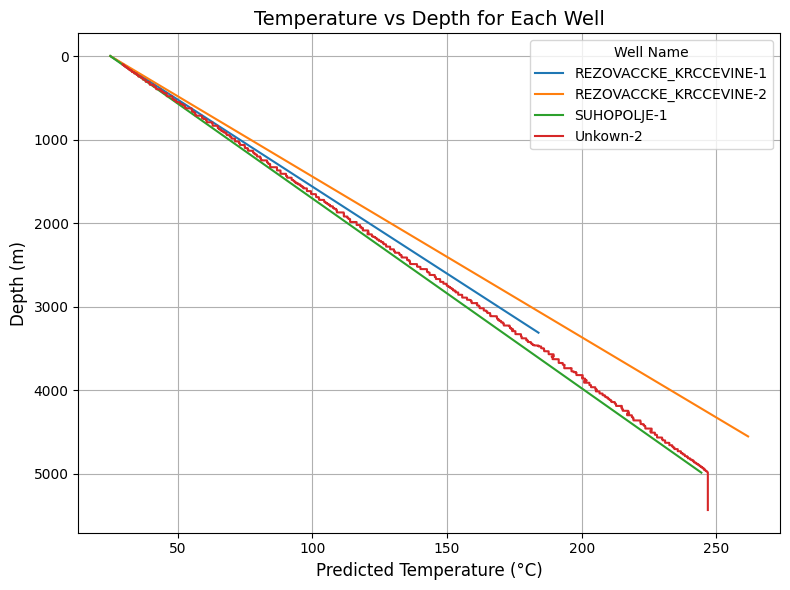

In [217]:
import matplotlib.pyplot as plt

# Group the data by Well_name
df_2 =  full_df[full_df['Well_name'].isin(["Unkown-2", "REZOVACCKE_KRCCEVINE-1", "REZOVACCKE_KRCCEVINE-2", "SUHOPOLJE-1"])]
grouped = df_2.groupby('Well_name')

# Create the plot
plt.figure(figsize=(8, 6))

# Plot each well
for well_name, group in grouped:
    plt.plot(group['Temp'], group['Depth'], label=well_name)

# Reverse the y-axis for depth increasing downwards
plt.gca().invert_yaxis()

# Add labels, title, and legend
plt.xlabel('Predicted Temperature (°C)', fontsize=12)
plt.ylabel('Depth (m)', fontsize=12)
plt.title('Temperature vs Depth', fontsize=14)
plt.legend(title='Well Name')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


## 5.2 Interpolate the prediction for the unknown well 2 under 5000 m

In [268]:
df = full_df[full_df["Well_name"]=="Unkown-2"]

<ipython-input-269-b28e06748bc0>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(grouped))


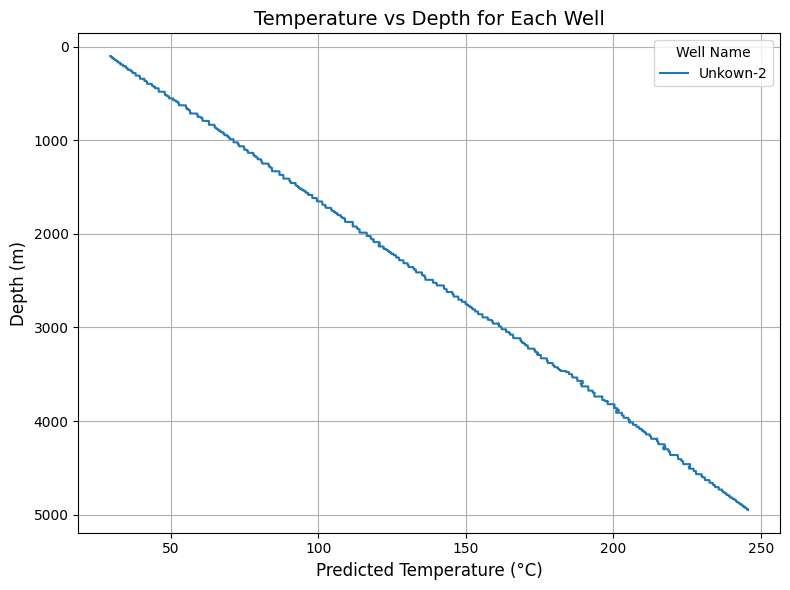

In [269]:
# Group the data by Well_name
df =  df[df["Depth"] < 4950]
grouped = df.groupby('Well_name')

# Create the plot
plt.figure(figsize=(8, 6))
colors = plt.cm.get_cmap('tab10', len(grouped))

# Plot each well with a vertical offset to separate the lines
for idx, (well_name, group) in enumerate(grouped):
    # Add a small offset to the depth to separate the wells visually
    offset = idx * 10
    plt.plot(group['Temp'], group['Depth'] + offset, label=well_name, color=colors(idx))

# Reverse the y-axis for depth increasing downwards
plt.gca().invert_yaxis()

# Add labels, title, and legend
plt.xlabel('Predicted Temperature (°C)', fontsize=12)
plt.ylabel('Depth (m)', fontsize=12)
plt.title('Temperature vs Depth for Each Well', fontsize=14)
plt.legend(title='Well Name')
plt.grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

Slope: 0.044815711685497306, Intercept: 26.225339083016948


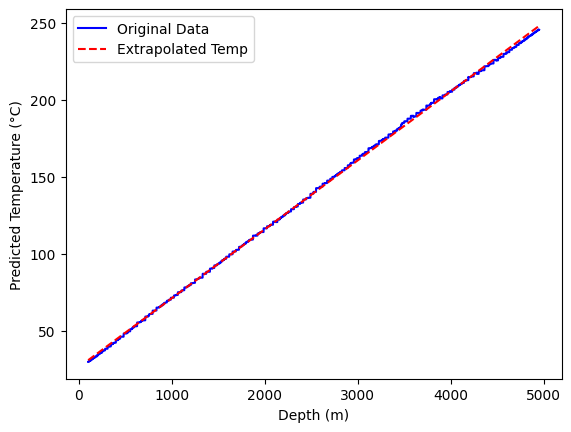

      Well_name         X          Y  Depth       Temp  Weight  \
19341  Unkown-2  691636.0  5072723.0  100.0  29.572689     NaN   
19342  Unkown-2  691636.0  5072723.0  100.1  29.572689     NaN   
19343  Unkown-2  691636.0  5072723.0  100.2  29.572689     NaN   
19344  Unkown-2  691636.0  5072723.0  100.3  29.572689     NaN   
19345  Unkown-2  691636.0  5072723.0  100.4  29.572689     NaN   

       Extrapolated_temp  
19341          30.706910  
19342          30.711392  
19343          30.715873  
19344          30.720355  
19345          30.724837  


In [270]:
# Fit a linear regression model using the data you have
X = df['Depth'].values.reshape(-1, 1)
y = df['Temp'].values

model = LinearRegression()
model.fit(X, y)

# Get the slope and intercept of the linear model
slope = model.coef_[0]
intercept = model.intercept_

# Debug: Print model coefficients
print(f"Slope: {slope}, Intercept: {intercept}")

# Extrapolate temperatures to a desired depth range
df['Extrapolated_temp'] = model.predict(X)

# Visualize the temperature extrapolation
plt.plot(df['Depth'], df['Temp'], label='Original Data', color='blue')
plt.plot(df['Depth'], df['Extrapolated_temp'], label='Extrapolated Temp', color='red', linestyle='dashed')
plt.xlabel('Depth (m)')
plt.ylabel('Predicted Temperature (°C)')
plt.legend()
plt.show()

print(df.head())

In [271]:
df

,Well_name,X,Y,Depth,Temp,Weight,Extrapolated_temp
19341,Unkown-2,691636.0,5072723.0,100.0,29.572689,NaN,30.706910
19342,Unkown-2,691636.0,5072723.0,100.1,29.572689,NaN,30.711392
19343,Unkown-2,691636.0,5072723.0,100.2,29.572689,NaN,30.715873
19344,Unkown-2,691636.0,5072723.0,100.3,29.572689,NaN,30.720355
19345,Unkown-2,691636.0,5072723.0,100.4,29.572689,NaN,30.724837
...,...,...,...,...,...,...,...
67837,Unkown-2,691636.0,5072723.0,4949.6,245.520877,NaN,248.045186
67838,Unkown-2,691636.0,5072723.0,4949.7,245.520877,NaN,248.049667
67839,Unkown-2,691636.0,5072723.0,4949.8,245.520877,NaN,248.054149
67840,Unkown-2,691636.0,5072723.0,4949.9,245.520877,NaN,248.058630


In [272]:
# Define the target depth
target_depth = 5435.0

# Calculate the slope and intercept for the linear equation of Extrapolated_temp vs Depth
slope, intercept = np.polyfit(df['Depth'], df['Extrapolated_temp'], 1)

# Generate new depth values from the maximum depth in the dataframe to the target depth
new_depths = np.arange(df['Depth'].max() + 0.1, target_depth, 0.1)

# Calculate the corresponding Extrapolated_temp values using the linear equation
new_extrapolated_temps = slope * new_depths + intercept

# Create a new DataFrame for the additional rows
new_data = {
    'Well_name': ['Unkown-2'] * len(new_depths),
    'X': [691636.0] * len(new_depths),
    'Y': [5072723.0] * len(new_depths),
    'Depth': new_depths,
    'Temp': [245.520877] * len(new_depths),
    'Extrapolated_temp': new_extrapolated_temps
}

# Convert the new data to a DataFrame
new_df = pd.DataFrame(new_data)

# Concatenate the original DataFrame with the new DataFrame
result_df = pd.concat([df, new_df], ignore_index=True)
print(result_df)

      Well_name         X          Y   Depth        Temp  Weight  \
0      Unkown-2  691636.0  5072723.0   100.0   29.572689     NaN   
1      Unkown-2  691636.0  5072723.0   100.1   29.572689     NaN   
2      Unkown-2  691636.0  5072723.0   100.2   29.572689     NaN   
3      Unkown-2  691636.0  5072723.0   100.3   29.572689     NaN   
4      Unkown-2  691636.0  5072723.0   100.4   29.572689     NaN   
...         ...       ...        ...     ...         ...     ...   
53346  Unkown-2  691636.0  5072723.0  5434.6  245.520877     NaN   
53347  Unkown-2  691636.0  5072723.0  5434.7  245.520877     NaN   
53348  Unkown-2  691636.0  5072723.0  5434.8  245.520877     NaN   
53349  Unkown-2  691636.0  5072723.0  5434.9  245.520877     NaN   
53350  Unkown-2  691636.0  5072723.0  5435.0  245.520877     NaN   

       Extrapolated_temp  
0              30.706910  
1              30.711392  
2              30.715873  
3              30.720355  
4              30.724837  
...                  

## 5.3 Concatenate and plot the Temperature again

In [274]:
result_df.head()

,Well_name,X,Y,Depth,Temp,Weight,Extrapolated_temp
0,Unkown-2,691636.0,5072723.0,100.0,29.572689,NaN,30.706910
1,Unkown-2,691636.0,5072723.0,100.1,29.572689,NaN,30.711392
2,Unkown-2,691636.0,5072723.0,100.2,29.572689,NaN,30.715873
3,Unkown-2,691636.0,5072723.0,100.3,29.572689,NaN,30.720355
4,Unkown-2,691636.0,5072723.0,100.4,29.572689,NaN,30.724837


In [275]:
 df_merged.head()

,Well_name,Depth,X,Y,Temp,Weight
0,VIROVITICA-3ALFA,0.0,686218.75,5073539.22,25.0000,0.0
1,VIROVITICA-3ALFA,0.1,686218.75,5073539.22,25.0049,0.0
2,VIROVITICA-3ALFA,0.2,686218.75,5073539.22,25.0098,0.0
3,VIROVITICA-3ALFA,0.3,686218.75,5073539.22,25.0147,0.0
4,VIROVITICA-3ALFA,0.4,686218.75,5073539.22,25.0196,0.0


In [277]:
#Unify the data frames columns
result_df = result_df.drop(["Temp","Weight"], axis = 1)
result_df["Temp"] = result_df["Extrapolated_temp"]
result_df = result_df.drop('Extrapolated_temp', axis = 1)
df_merged =  df_merged.drop("Weight", axis = 1)
full_df_2 = pd.concat([result_df, df_merged], axis = 0)

<ipython-input-281-81ce21facbf2>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(grouped))


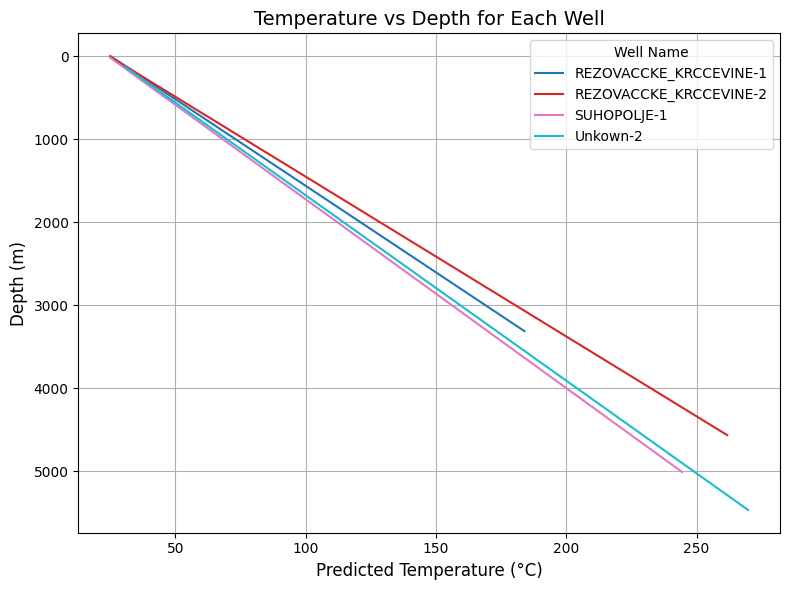

In [281]:
# Group the data by Well_name
full_df_2 =  full_df_2[full_df_2['Well_name'].isin(["Unkown-2", "REZOVACCKE_KRCCEVINE-1", "REZOVACCKE_KRCCEVINE-2", "SUHOPOLJE-1"])]
grouped = full_df_2.groupby('Well_name')

# Create the plot
plt.figure(figsize=(8, 6))
colors = plt.cm.get_cmap('tab10', len(grouped))

# Plot each well with a vertical offset to separate the lines
for idx, (well_name, group) in enumerate(grouped):
    offset = idx * 10
    plt.plot(group['Temp'], group['Depth'] + offset, label=well_name, color=colors(idx))

plt.gca().invert_yaxis()

# Add labels, title, and legend
plt.xlabel('Predicted Temperature (°C)', fontsize=12)
plt.ylabel('Depth (m)', fontsize=12)
plt.title('Temperature vs Depth for Each Well', fontsize=14)
plt.legend(title='Well Name')
plt.grid(True)

plt.tight_layout()
plt.show()

## 5.4 Unknown-1

In [282]:
df = full_df[full_df["Well_name"]=="Unkown-1"]

Slope: 0.04899441306644184, Intercept: 25.00743147904477


<ipython-input-283-db5512b5cf19>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Extrapolated_temp'] = model.predict(X)


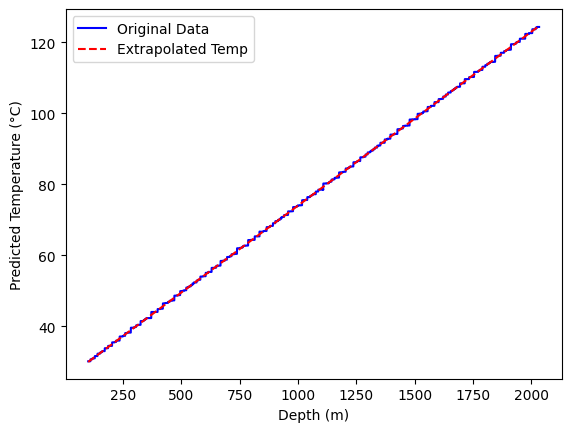

  Well_name         X          Y  Depth       Temp  Weight  Extrapolated_temp
0  Unkown-1  683447.0  5072765.0  100.0  30.078144     NaN          29.906873
1  Unkown-1  683447.0  5072765.0  100.1  30.078144     NaN          29.911772
2  Unkown-1  683447.0  5072765.0  100.2  30.078144     NaN          29.916672
3  Unkown-1  683447.0  5072765.0  100.3  30.078144     NaN          29.921571
4  Unkown-1  683447.0  5072765.0  100.4  30.078144     NaN          29.926471


In [283]:
# Fit a linear regression model using the data you have
X = df['Depth'].values.reshape(-1, 1)
y = df['Temp'].values

model = LinearRegression()
model.fit(X, y)

# Get the slope and intercept of the linear model
slope = model.coef_[0]
intercept = model.intercept_
print(f"Slope: {slope}, Intercept: {intercept}")

# Extrapolate temperatures to a desired depth range
df['Extrapolated_temp'] = model.predict(X)

# Visualize the temperature extrapolation
plt.plot(df['Depth'], df['Temp'], label='Original Data', color='blue')
plt.plot(df['Depth'], df['Extrapolated_temp'], label='Extrapolated Temp', color='red', linestyle='dashed')
plt.xlabel('Depth (m)')
plt.ylabel('Predicted Temperature (°C)')
plt.legend()
plt.show()

print(df.head())

In [284]:
#Unify the data frames
df1 = df.drop(["Temp","Weight"], axis = 1)
df1["Temp"] = df1["Extrapolated_temp"]
df1 = df1.drop('Extrapolated_temp', axis = 1)
full_df_1 = pd.concat([df1, df_merged], axis = 0)

<ipython-input-287-3abcac2af0fa>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(grouped))


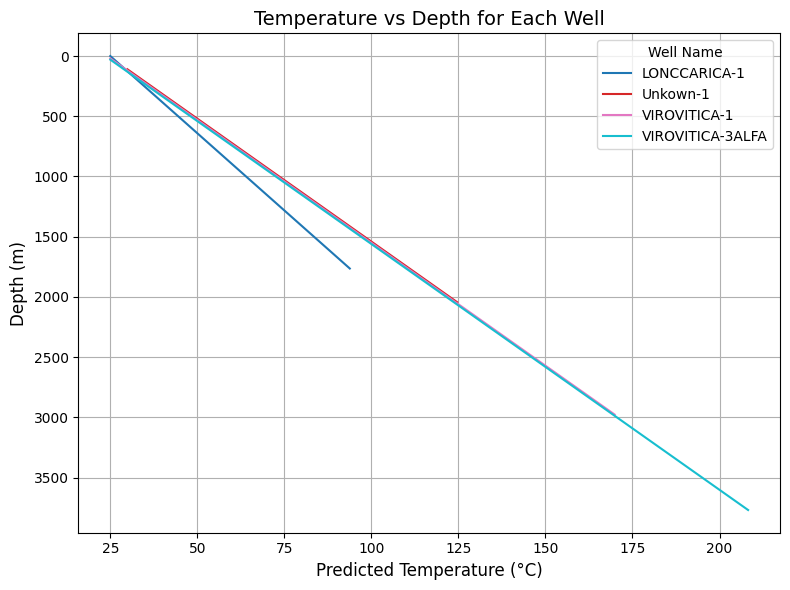

In [287]:
# Group the data by Well_name
full_df_1 =  full_df_1[full_df_1['Well_name'].isin(["Unkown-1", "VIROVITICA-3ALFA", "VIROVITICA-1", "LONCCARICA-1"])]
grouped = full_df_1.groupby('Well_name')

# Create the plot
plt.figure(figsize=(8, 6))
colors = plt.cm.get_cmap('tab10', len(grouped))

# Plot each well with a vertical offset to separate the lines
for idx, (well_name, group) in enumerate(grouped):
    offset = idx * 10
    plt.plot(group['Temp'], group['Depth'] + offset, label=well_name, color=colors(idx))

# Reverse the y-axis for depth increasing downwards
plt.gca().invert_yaxis()

# Add labels, title, and legend
plt.xlabel('Predicted Temperature (°C)', fontsize=12)
plt.ylabel('Depth (m)', fontsize=12)
plt.title('Temperature vs Depth for Each Well', fontsize=14)
plt.legend(title='Well Name')
plt.grid(True)

plt.tight_layout()
plt.show()


# 6. Combine and plot the entire data frame

In [288]:
full_df = pd.concat([df1, result_df, df_merged], axis = 0)

In [289]:
full_df

,Well_name,X,Y,Depth,Temp
0,Unkown-1,683447.00,5072765.00,100.0,29.906873
1,Unkown-1,683447.00,5072765.00,100.1,29.911772
2,Unkown-1,683447.00,5072765.00,100.2,29.916672
3,Unkown-1,683447.00,5072765.00,100.3,29.921571
4,Unkown-1,683447.00,5072765.00,100.4,29.926471
...,...,...,...,...,...
213131,REZOVACCKE_KRCCEVINE-2,688872.79,5073318.89,4553.6,261.787201
213132,REZOVACCKE_KRCCEVINE-2,688872.79,5073318.89,4553.7,261.792389
213133,REZOVACCKE_KRCCEVINE-2,688872.79,5073318.89,4553.8,261.797607
213134,REZOVACCKE_KRCCEVINE-2,688872.79,5073318.89,4553.9,261.802795


<ipython-input-290-d96fb3fb914f>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(grouped))


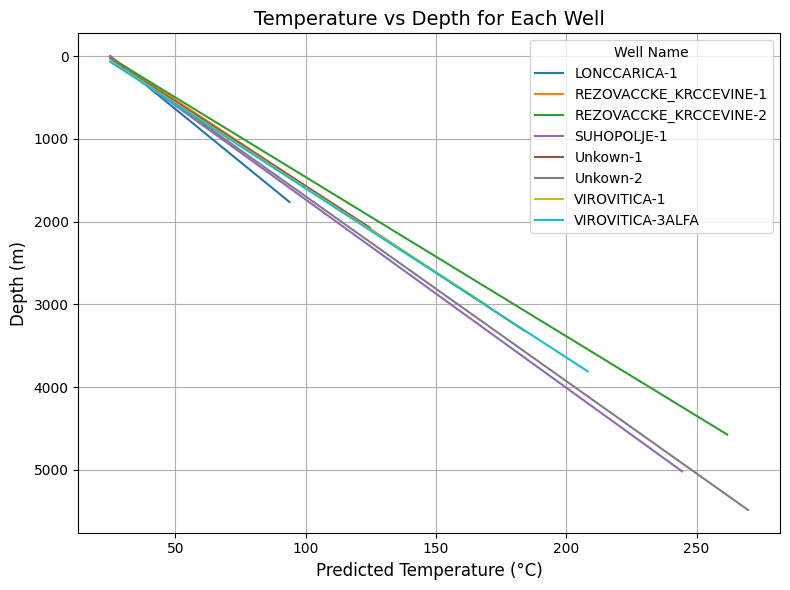

In [290]:
# Group the data by Well_name
grouped = full_df.groupby('Well_name')

# Create the plot
plt.figure(figsize=(8, 6))
colors = plt.cm.get_cmap('tab10', len(grouped))

# Plot each well with a vertical offset to separate the lines
for idx, (well_name, group) in enumerate(grouped):
    offset = idx * 10
    plt.plot(group['Temp'], group['Depth'] + offset, label=well_name, color=colors(idx))

# Reverse the y-axis for depth increasing downwards
plt.gca().invert_yaxis()

# Add labels, title, and legend
plt.xlabel('Predicted Temperature (°C)', fontsize=12)
plt.ylabel('Depth (m)', fontsize=12)
plt.title('Temperature vs Depth for Each Well', fontsize=14)
plt.legend(title='Well Name')
plt.grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [291]:
#Save the data frame to csv
full_df.to_csv("Temperature_prediction")